In [2]:
%%html
<style>
table {float:left}
</style>

## Data analysis:

### Train set

| Label name | | Number of images |
| - | | - | 
| hyundai | | 302 | 
| lexus | | 301 | 
| mazda | | 317 | 
| mercedes | | 342 | 
| opel | | 301 | 
| skoda | | 314 | 
| toyota | | 306 | 
| volkswagen | | 330 | 

### Test set
| Label name | | Number of images |
| - | | - | 
| hyundai | | 50 | 
| lexus | | 50 | 
| mazda | | 50 | 
| mercedes | | 50 | 
| opel | | 50 | 
| skoda | | 50 | 
| toyota | | 50 | 
| volkswagen | | 50 | 

In [2]:
%matplotlib inline

### Imports

In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor, Resize, ToPILImage
from torchvision.transforms.functional import to_grayscale, to_tensor, rotate
import matplotlib.pyplot as plt

import os
import random
import pandas as pd
from torchvision.io import read_image

from torch.utils.data import DataLoader

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

from sklearn.metrics import classification_report, confusion_matrix

from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid
import seaborn as sn
import numpy as np

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Useful functions to retrive the data

In [2]:
# create a annotations_file.csv (index -> img (name), label (int))

def getLabelList(path):
    only_dirs = [ name for name in os.listdir(path) if 
                 os.path.isdir(os.path.join(path, name)) ]

    ret = {}
    index = 0
    
    for d in only_dirs:
        new_path = path + d
        label = only_dirs.index(d)
        # print(len(os.listdir(new_path)))
        for img in [ name for name in os.listdir(new_path) ]:
            ret[index] = [img, label]
            index += 1
    
    return pd.Series(ret)

In [3]:
# create the pool of images (with a series that contains all the images, more deeply: index -> abs path, label (int), class (string))

def getImgPool(path):
    only_dirs = [ name for name in os.listdir(path) if 
                 os.path.isdir(os.path.join(path, name)) ]

    ret = {}
    index = 0
    
    for d in only_dirs:
        new_path = path + d
        label = only_dirs.index(d)
        # cnt = 0
        for img in [ name for name in os.listdir(new_path) ]:
            abs_path = new_path + '/' + img
            ret[index] = [abs_path, label, d]
            index += 1
            # cnt += 1
        # print(f"Label: {d} - Number: {cnt}")
    
    return pd.Series(ret)

### Defining the custom dataset (structure that holds the data)

In [4]:
wrong_images_path = []
import traceback

class CustomImageDataset(Dataset):
    def __init__(self, path_labels, transform=None, target_transform=None):
        self.img_labels = getLabelList(path_labels)
        self.images = getImgPool(path_labels)
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        try: 
            image = read_image(self.images.loc[idx][0])
        except Exception:
            print('Found error at {} {}'.format(self.images.loc[idx][0], idx))
        #     wrong_images_path.append(self.images.loc[img_name][0])
            #return torch.zeros((1, 600, 600)), -1
        # image = read_image(self.images.loc[img_name][0])
        if image.shape[0] >= 3: #apply grayscale to colored img
            image = to_tensor(to_grayscale(ToPILImage()(image), num_output_channels=1))
        else: #we have a greyscaled image, move it into tensor 
            image = to_tensor(ToPILImage()(image))
            
        image = Resize((300, 300))(image)
        #data augmentation
        #prob = torch.randint(100, size=(1,)).item()
        
        #prob = 0 # use this if no data augmentation
        fr = random.choices([0,1],[0.2,0.8])[0]
        if fr == 1: 
            angle = torch.randint(60, size=(1,)).item() - 30
            #print (f'Rotate: {angle}')
            image = rotate(image, angle)        
        
        #image = image.permute(1,2,0) #made to be shown on matplotlib
        label = self.img_labels.loc[idx][1]
        #if self.transform:
        #    image = self.transform(image)
        #if self.target_transform:
        #    label = self.target_transform(label)
        
        return image, label

### Creating the 2 dataset and testing

In [5]:
train_path = 'data/car_brand_logos/Train/'
test_path = 'data/car_brand_logos/Test/'

# train_data = CustomImageDataset(path_labels=train_path, transform=ToTensor(), num_of_channels=3)
# test_data = CustomImageDataset(path_labels=test_path, transform=ToTensor(), num_of_channels=3)

train_data = CustomImageDataset(path_labels=train_path, transform=ToTensor(), target_transform=ToTensor())

test_data = CustomImageDataset(path_labels=test_path, transform=ToTensor(), target_transform=ToTensor())

print (f'train dataset: {train_data.__len__()}')
print (f'test dataset: {test_data.__len__()}')

train dataset: 2502
test dataset: 399


In [8]:
# for i in range(train_data.__len__()):
#     img, label = train_data[i]

# for i in range(test_data.__len__()):
#     img, label = test_data[i]
    
    
# wrong_images_path

torch.Size([1, 300, 300]) torch.float32 7
torch.Size([1, 300, 300]) torch.float32 0
torch.Size([1, 300, 300]) torch.float32 2
torch.Size([1, 300, 300]) torch.float32 3
torch.Size([1, 300, 300]) torch.float32 4
torch.Size([1, 300, 300]) torch.float32 6
torch.Size([1, 300, 300]) torch.float32 6
torch.Size([1, 300, 300]) torch.float32 1
torch.Size([1, 300, 300]) torch.float32 1


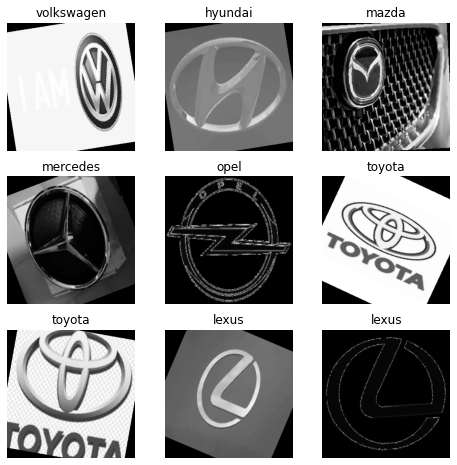

In [6]:
#testing dataset if images are loaded

only_dirs = [ name for name in os.listdir(train_path) if 
                 os.path.isdir(os.path.join(train_path, name)) ]

diz = {}
nocl=0 #num of classes
for d in only_dirs:
    diz[nocl] = d
    nocl+=1

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item() 
    img, label = train_data[sample_idx]
    print (img.shape, img.dtype, label)
    figure.add_subplot(rows, cols, i)
    plt.title(diz[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap='gray')
    # plt.imshow(img.squeeze())
plt.show()

In [10]:
# img, label = train_data[300]

# print(img.shape)

# plt.imshow(img.squeeze(), cmap='gray')

### creating dataloader (who iterate on data, create batches and shuffles it)


Feature batch shape: torch.Size([8, 1, 300, 300])
Labels batch shape: torch.Size([8])


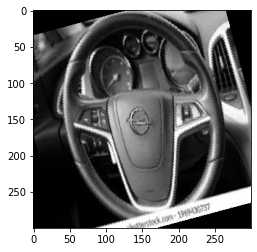

Label: opel


In [8]:
train_dl = DataLoader(train_data, batch_size=8, shuffle=True, pin_memory=True)
test_dl = DataLoader(test_data, batch_size=8, shuffle=True)

#dataloader test (ask a batch or a sample)
images, labels = next(iter(train_dl)) #picking a batch
print(f"Feature batch shape: {images.size()}")
print(f"Labels batch shape: {labels.size()}")
img = images[0].permute(1,2,0) #picking the first img and label of the batch
label = labels[0]
plt.imshow(img, cmap='gray')
plt.show()
print(f"Label: {diz[label.item()]}")

In [9]:
labels

tensor([4, 0, 0, 5, 2, 1, 1, 7])

In [23]:
for i, data in enumerate(test_dl, 0):
    True

Found error at data/car_brand_logos/Test/hyundai/hyundai-logo-sticker__0379804161130688.jpg 32


In [12]:
# os.rename('./data/car_brand_logos/Train/mercedes/r6.JPG', './data/car_brand_logos/Train/mercedes/r6.jpg')
# image = read_image('./data/car_brand_logos/Train/volkswagen/vosvos-volkswagen-logo-patches-arma-pec-kot-yamasi__1548797389090801.jpg')
# image = image.permute(1,2,0)
# plt.imshow(image, cmap='gray')
# plt.show()

### Defining the neural network

In [10]:
print("GPU compute available: ", torch.cuda.is_available())


GPU compute available:  True


In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(device)

cuda:0


In [12]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        
        #conv1: 1 input image channel (image channel, 1 gray, 3 rgb), 6 output channels (depth [K]), 5x5 square convolution kernel, DEFAULT: stride = 1,1, padding = 0
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)        
        self.fc_layer1 = nn.Linear(16 * 72 * 72, 120)        
        self.fc_layer2 = nn.Linear(120, 84)
        self.fc_layer3 = nn.Linear(84, nocl) # nocl is the num of classes

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = self.pool(F.relu(self.conv1(x)))
        #print ('conv1', x.shape)
        # If the size is a square, you can specify with a single number
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except the batch dimension
        #print ('flatten', x.shape)
        x = F.relu(self.fc_layer1(x))
        x = F.relu(self.fc_layer2(x))
        x = self.fc_layer3(x)
        return x

In [13]:
net = Net()
net.to(device)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc_layer1): Linear(in_features=82944, out_features=120, bias=True)
  (fc_layer2): Linear(in_features=120, out_features=84, bias=True)
  (fc_layer3): Linear(in_features=84, out_features=8, bias=True)
)

In [15]:
#test
params = list(net.parameters())
print(len(params))
print(params[0].size())  # conv1's .weight

10
torch.Size([6, 1, 5, 5])


In [14]:
# loss function
criterion = nn.CrossEntropyLoss()
# use gradient descent
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### Tensorboard setup

start tensorboard: `tensorboard --logdir=Users\eliad\Tesi\ProgettoTesi\runs\car_brands_1`

In [41]:
writer = SummaryWriter('runs/car_brands_n')

In [ ]:
# get some random training images
dataiter = iter(train_dl)
images, labels = dataiter.next()

#visualizing and adding images into tb
for idx in range(4):    
    img = images[idx]
    img = img.permute(1,2,0)
    plt.imshow(img, cmap='gray')
    plt.show()
    print (img.shape, img.dtype)
    writer.add_image(f"car_brands_images_{idx+1}", img)

In [39]:
    
writer.close()

### Adding the graph of the network into Tensorboard

In [20]:
images = images.permute(0, 3, 1, 2) #move to tensor mode

writer.add_graph(net, images)
writer.close()

### Adding the projector 

In [21]:
tmp_dl = DataLoader(train_data, batch_size=100, shuffle=True)
images, labels = next(iter(tmp_dl))

# get the class labels for each image
class_labels = [diz[lab.item()] for lab in labels]


images = images.permute(0,3,1,2) #tensor mode
images = Resize((28, 28))(images)

features = images.view(-1, 28 * 28)
writer.add_embedding(features,
                    metadata=class_labels,
                    label_img=images)
writer.close()

### Confusion matrix during training

In [40]:
def createConfusionMatrix(loader):
    y_pred = [] # save predction
    y_true = [] # save ground truth

    # iterate over data
    for inputs, labels in loader:
        inputs = inputs.permute(0, 3, 1, 2)
        output = net(inputs)  # Feed Network

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output)  # save prediction

        labels = labels.data.cpu().numpy()
        y_true.extend(labels)  # save ground truth

    # constant for classes
    classes = diz.values()

    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) * 10, index=[i for i in classes],
                         columns=[i for i in classes])
    plt.figure(figsize=(10, 7), dpi=150)    
    return sn.heatmap(df_cm, annot=True).get_figure()

### Training the network

In [16]:
print(next(net.parameters()).device)

cuda:0


In [17]:
for epoch in range(25):  # loop over the dataset multiple times
    net.train()
    running_loss = 0.0
    for i, data in enumerate(train_dl):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        # inputs, labels = data[0].to(device), data[1].to(device)
        #print (inputs.shape)
        #inputs = inputs.permute(0, 3, 1, 2) # to get a shape of [64, 1, 600, 600]
        inputs = inputs.to(device)
        labels = labels.to(device)
        #print (inputs.device, label.device)

        # inputs = inputs.view(64, -1) #1° param specifico io, altri calcola lui (-1)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        #print (outputs.device)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        skip = 50
        if i > 0  and i % 50 == 0:    # print every 360 images (8 images per batch, 45 loops)
            print(f'[{epoch + 1}, {i+1}/{len(train_dl)}] loss: {(running_loss/skip):.3f}')
            # ...log the running loss
            #writer.add_scalar('training loss',
            #            running_loss / 1000,
            #            epoch * len(train_dl) + i)
            running_loss = 0.0

    #end of an epoch, calculate loss on test set (since it's small and there's no need to split)
    with torch.no_grad():
        test_loss = 0
        test_batch = 0
        for _, data in enumerate(test_dl):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            #inputs = inputs.permute(0, 3, 1, 2)
            
            net.eval()
            
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            test_batch += 1
        print(f"[{epoch + 1}] test loss: {(test_loss/test_batch):.3f}")
    # confusion matrix (added from extra step)
    #writer.add_figure("Confusion matrix", createConfusionMatrix(test_dl), epoch)

print('Finished Training')

#saving the trained model
PATH = 'auto_brand_n.pth'
torch.save(net.state_dict(), PATH)

[1, 51/313] loss: 2.124
[1, 101/313] loss: 2.084


Corrupt JPEG data: 7 extraneous bytes before marker 0xee


[1, 151/313] loss: 2.076
[1, 201/313] loss: 2.083
[1, 251/313] loss: 2.082
[1, 301/313] loss: 2.079
[1] test loss: 2.077
[2, 51/313] loss: 2.116
[2, 101/313] loss: 2.075
[2, 151/313] loss: 2.076


Corrupt JPEG data: 7 extraneous bytes before marker 0xee


[2, 201/313] loss: 2.078
[2, 251/313] loss: 2.080
[2, 301/313] loss: 2.074
[2] test loss: 2.074
[3, 51/313] loss: 2.115
[3, 101/313] loss: 2.081


Corrupt JPEG data: 7 extraneous bytes before marker 0xee


[3, 151/313] loss: 2.074
[3, 201/313] loss: 2.065
[3, 251/313] loss: 2.067
[3, 301/313] loss: 2.066
[3] test loss: 2.071


Corrupt JPEG data: 7 extraneous bytes before marker 0xee


[4, 51/313] loss: 2.103
[4, 101/313] loss: 2.067
[4, 151/313] loss: 2.068
[4, 201/313] loss: 2.074
[4, 251/313] loss: 2.061
[4, 301/313] loss: 2.062
[4] test loss: 2.063
[5, 51/313] loss: 2.109
[5, 101/313] loss: 2.056
[5, 151/313] loss: 2.061
[5, 201/313] loss: 2.065


Corrupt JPEG data: 7 extraneous bytes before marker 0xee


[5, 251/313] loss: 2.065
[5, 301/313] loss: 2.064
[5] test loss: 2.054
[6, 51/313] loss: 2.094
[6, 101/313] loss: 2.052
[6, 151/313] loss: 2.055
[6, 201/313] loss: 2.068
[6, 251/313] loss: 2.057


Corrupt JPEG data: 7 extraneous bytes before marker 0xee


[6, 301/313] loss: 2.037
[6] test loss: 2.060
[7, 51/313] loss: 2.092
[7, 101/313] loss: 2.039
[7, 151/313] loss: 2.025
[7, 201/313] loss: 2.032


Corrupt JPEG data: 7 extraneous bytes before marker 0xee


[7, 251/313] loss: 2.040
[7, 301/313] loss: 2.017
[7] test loss: 2.038
[8, 51/313] loss: 2.065
[8, 101/313] loss: 2.022
[8, 151/313] loss: 1.995


Corrupt JPEG data: 7 extraneous bytes before marker 0xee


[8, 201/313] loss: 2.003
[8, 251/313] loss: 2.013
[8, 301/313] loss: 2.015
[8] test loss: 2.029
[9, 51/313] loss: 2.040
[9, 101/313] loss: 1.985
[9, 151/313] loss: 2.003
[9, 201/313] loss: 2.014


Corrupt JPEG data: 7 extraneous bytes before marker 0xee


[9, 251/313] loss: 1.974
[9, 301/313] loss: 1.978
[9] test loss: 2.032
[10, 51/313] loss: 2.013
[10, 101/313] loss: 1.972
[10, 151/313] loss: 1.967
[10, 201/313] loss: 1.952
[10, 251/313] loss: 1.995


Corrupt JPEG data: 7 extraneous bytes before marker 0xee


[10, 301/313] loss: 1.970
[10] test loss: 1.976


Corrupt JPEG data: 7 extraneous bytes before marker 0xee


[11, 51/313] loss: 1.931
[11, 101/313] loss: 1.944
[11, 151/313] loss: 1.883
[11, 201/313] loss: 1.936
[11, 251/313] loss: 1.896
[11, 301/313] loss: 1.894
[11] test loss: 1.931


Corrupt JPEG data: 7 extraneous bytes before marker 0xee


[12, 51/313] loss: 1.896
[12, 101/313] loss: 1.808
[12, 151/313] loss: 1.845
[12, 201/313] loss: 1.832
[12, 251/313] loss: 1.791
[12, 301/313] loss: 1.813
[12] test loss: 1.819
[13, 51/313] loss: 1.796
[13, 101/313] loss: 1.687
[13, 151/313] loss: 1.718
[13, 201/313] loss: 1.702


Corrupt JPEG data: 7 extraneous bytes before marker 0xee


[13, 251/313] loss: 1.622
[13, 301/313] loss: 1.738
[13] test loss: 1.891
[14, 51/313] loss: 1.620
[14, 101/313] loss: 1.671
[14, 151/313] loss: 1.620
[14, 201/313] loss: 1.534


Corrupt JPEG data: 7 extraneous bytes before marker 0xee


[14, 251/313] loss: 1.525
[14, 301/313] loss: 1.523
[14] test loss: 1.746
[15, 51/313] loss: 1.454
[15, 101/313] loss: 1.425
[15, 151/313] loss: 1.515
[15, 201/313] loss: 1.485


Corrupt JPEG data: 7 extraneous bytes before marker 0xee


[15, 251/313] loss: 1.435
[15, 301/313] loss: 1.464
[15] test loss: 1.686


Corrupt JPEG data: 7 extraneous bytes before marker 0xee


[16, 51/313] loss: 1.404
[16, 101/313] loss: 1.367
[16, 151/313] loss: 1.373
[16, 201/313] loss: 1.403
[16, 251/313] loss: 1.386
[16, 301/313] loss: 1.425
[16] test loss: 1.658


Corrupt JPEG data: 7 extraneous bytes before marker 0xee


[17, 51/313] loss: 1.242
[17, 101/313] loss: 1.250
[17, 151/313] loss: 1.286
[17, 201/313] loss: 1.288
[17, 251/313] loss: 1.316
[17, 301/313] loss: 1.308
[17] test loss: 1.696


Corrupt JPEG data: 7 extraneous bytes before marker 0xee


[18, 51/313] loss: 1.263
[18, 101/313] loss: 1.147
[18, 151/313] loss: 1.112
[18, 201/313] loss: 1.319
[18, 251/313] loss: 1.180
[18, 301/313] loss: 1.246
[18] test loss: 1.737
[19, 51/313] loss: 1.228
[19, 101/313] loss: 1.085
[19, 151/313] loss: 1.216


Corrupt JPEG data: 7 extraneous bytes before marker 0xee


[19, 201/313] loss: 1.146
[19, 251/313] loss: 1.041
[19, 301/313] loss: 1.207
[19] test loss: 1.717
[20, 51/313] loss: 1.076


Corrupt JPEG data: 7 extraneous bytes before marker 0xee


[20, 101/313] loss: 1.151
[20, 151/313] loss: 1.063
[20, 201/313] loss: 1.101
[20, 251/313] loss: 1.060
[20, 301/313] loss: 1.130
[20] test loss: 1.732
[21, 51/313] loss: 1.056
[21, 101/313] loss: 1.121
[21, 151/313] loss: 1.011


Corrupt JPEG data: 7 extraneous bytes before marker 0xee


[21, 201/313] loss: 1.064
[21, 251/313] loss: 1.070
[21, 301/313] loss: 1.128
[21] test loss: 1.582
[22, 51/313] loss: 1.058
[22, 101/313] loss: 0.965


Corrupt JPEG data: 7 extraneous bytes before marker 0xee


[22, 151/313] loss: 0.963
[22, 201/313] loss: 0.963
[22, 251/313] loss: 0.997
[22, 301/313] loss: 1.008
[22] test loss: 1.851
[23, 51/313] loss: 0.877


Corrupt JPEG data: 7 extraneous bytes before marker 0xee


[23, 101/313] loss: 0.868
[23, 151/313] loss: 0.953
[23, 201/313] loss: 0.974
[23, 251/313] loss: 1.021
[23, 301/313] loss: 1.093
[23] test loss: 1.632


Corrupt JPEG data: 7 extraneous bytes before marker 0xee


[24, 51/313] loss: 0.972
[24, 101/313] loss: 0.838
[24, 151/313] loss: 0.895
[24, 201/313] loss: 0.810
[24, 251/313] loss: 0.912
[24, 301/313] loss: 0.910
[24] test loss: 1.768
[25, 51/313] loss: 0.796
[25, 101/313] loss: 0.785
[25, 151/313] loss: 0.856
[25, 201/313] loss: 0.961
[25, 251/313] loss: 0.952


Corrupt JPEG data: 7 extraneous bytes before marker 0xee


[25, 301/313] loss: 0.956
[25] test loss: 1.742
Finished Training


### Testing the network on test set

In [24]:
loaded = Net()
loaded.load_state_dict(torch.load("auto_brand_n.pth"))

<All keys matched successfully>

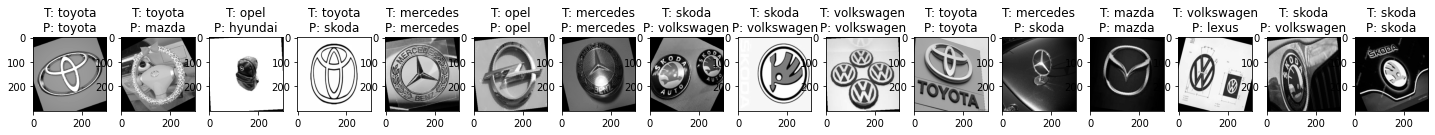

In [34]:
images, labels = next(iter(test_dl)) #picking a batch

n_imgs = len(images)
img = images.to(device)
label = labels.to(device)

preds = net(img)
_, best_pred = torch.max(preds.data, 1)

fig, axs = plt.subplots(figsize=(25,4), nrows=1, ncols=n_imgs)

for i in range(n_imgs):
    axs[i].imshow(img[i].permute(1,2,0).cpu(), cmap='gray')
    #axs[i].suptitle('True: {}'.format(diz[label.item()]))
    
    #predicting the class of the image
    #imgs = images.permute(0, 3, 1, 2)
    
    #preds = net(torch.unsqueeze(img, dim=0))
    #_, best_pred = torch.max(preds.data, 1)
    
    axs[i].set_title('T: {}\nP: {}'.format(diz[label[i].item()], diz[best_pred[i].item()]))
    # print(f"Numero di classi: {nocl}")
    # print(f"Dimensioni delle predizioni del batch da 64 elementi: {preds.size()}")
    # print(f"Predizioni dell'elemento scelto: {preds[rnd_i]}")
    # print(diz.values())
    
    #plt.show()

In [35]:
# 1. gets the probability predictions in a test_size x num_classes Tensor
# 2. gets the preds in a test_size Tensor
class_probs = []
class_label = []
with torch.no_grad():
    for data in test_dl:
        images, labels = data
        images = images.to(device)#.permute(0, 3, 1, 2)
        labels = labels.to(device)
        output = net(images)
        class_probs_batch = [F.softmax(el, dim=0) for el in output]

        class_probs.append(class_probs_batch)
        class_label.append(labels)

test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
test_label = torch.cat(class_label)

# helper function
def add_pr_curve_tensorboard(class_index, test_probs, test_label, global_step=0):
    '''
    Takes in a "class_index" from 0 to 9 and plots the corresponding
    precision-recall curve
    '''
    tensorboard_truth = test_label == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(diz[class_index],
                        tensorboard_truth,
                        tensorboard_probs,
                        global_step=global_step)
    writer.close()

# plot all the pr curves
#for i in range(len(diz.values())):
#    add_pr_curve_tensorboard(i, test_probs, test_label)

In [36]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in diz}
total_pred = {classname: 0 for classname in diz}

y_true = []
y_pred = []

# again no gradients needed
with torch.no_grad():
    for data in test_dl:
        images, labels = data
        images = images.to(device)#.permute(0, 3, 1, 2)
        labels = labels.to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[label.item()] += 1
            total_pred[label.item()] += 1
            y_true.append(label.cpu())
            y_pred.append(prediction.cpu())

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {diz[classname]} is {accuracy:.1f} %')

Accuracy for class: hyundai is 42.9 %
Accuracy for class: lexus is 28.0 %
Accuracy for class: mazda is 78.0 %
Accuracy for class: mercedes is 52.0 %
Accuracy for class: opel is 38.0 %
Accuracy for class: skoda is 58.0 %
Accuracy for class: toyota is 10.0 %
Accuracy for class: volkswagen is 44.0 %


In [37]:
#stampa report classificazioni
print(classification_report(y_true, y_pred, target_names=diz.values()))

              precision    recall  f1-score   support

     hyundai       0.55      0.43      0.48        49
       lexus       0.33      0.28      0.30        50
       mazda       0.45      0.78      0.57        50
    mercedes       0.55      0.52      0.54        50
        opel       0.43      0.38      0.40        50
       skoda       0.30      0.58      0.40        50
      toyota       0.62      0.10      0.17        50
  volkswagen       0.59      0.44      0.51        50

    accuracy                           0.44       399
   macro avg       0.48      0.44      0.42       399
weighted avg       0.48      0.44      0.42       399



In [65]:
import torch
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 5

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [66]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

In [67]:
labels

tensor([1, 5, 5, 6, 4])

In [25]:
trainset.__len__()

50000

In [29]:
# writer.add_figure("Final matrix", createConfusionMatrix(test_dl), 0)